In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
stock = yf.Ticker("WIPRO.NS")
d = stock.history(interval="1d", period="15y")
d.drop(['Dividends','Stock Splits'], axis=1, inplace=True)
d.to_csv('Stock_data')
df = pd.read_csv('Stock_data')
StockData = df.sort_values('Date')
print("Number of rows and columns:", StockData.shape)
StockData.head()


Number of rows and columns: (3700, 6)


Date       Open        High        Low      Close   Volume
0  2007-07-23  97.480038   98.860200  96.987809  98.252151  2989244
1  2007-07-24  98.348651   98.445168  97.122913  97.576530  2071595
2  2007-07-25  97.480034   97.673062  95.742765  96.292900  6528221
3  2007-07-26  96.688623  102.691847  95.569050  99.217308  8453915
4  2007-07-27  98.686478   98.686478  94.584595  95.105774  5232941

In [5]:
StockData
type(StockData)
StockData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3700 entries, 0 to 3699
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3700 non-null   object 
 1   Open    3700 non-null   float64
 2   High    3700 non-null   float64
 3   Low     3700 non-null   float64
 4   Close   3700 non-null   float64
 5   Volume  3700 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 202.3+ KB


<AxesSubplot:xlabel='Date'>

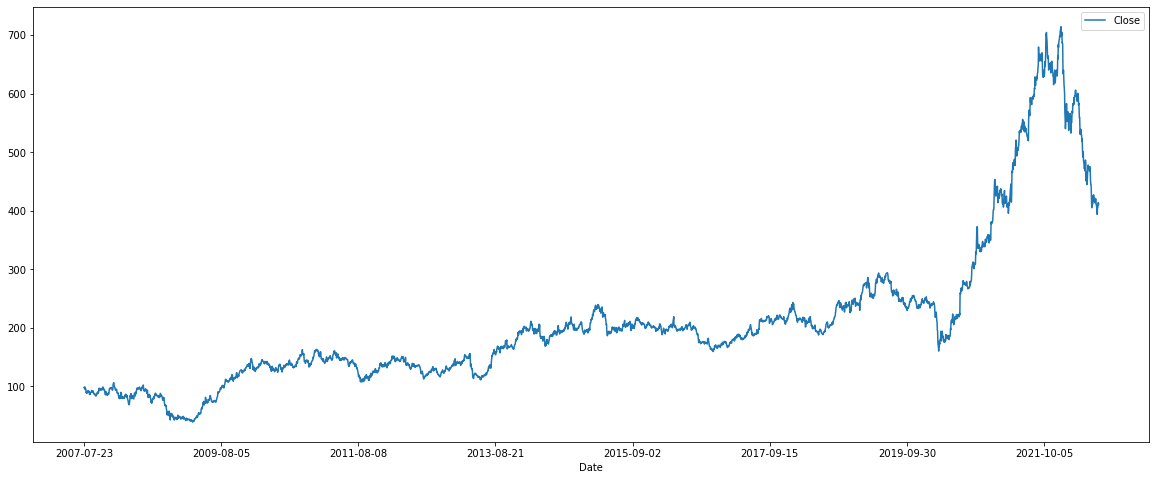

In [6]:
# Creating a column as date
#StockData['TradeDate']=StockData.index
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='Date', y='Close', kind='line', figsize=(20,8))

In [7]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
# Choosing between Standardization or normalization

#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[98.25215149]
 [97.57653046]
 [96.29290009]
 [99.21730804]
 [95.10577393]]
### After Normalization ###


array([[0.08737316],
       [0.08637241],
       [0.08447106],
       [0.08880278],
       [0.08271265]])

In [8]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(3690, 10, 1)

#### Output Data shape ####
(3690, 1)


In [9]:
# Choosing the number of testing data records
TestingRecords=10
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(3680, 10, 1)
(3680, 1)

#### Testing Data shape ####
(10, 10, 1)
(10, 1)


In [10]:
#Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.08737316]
 [0.08637241]
 [0.08447106]
 [0.08880278]
 [0.08271265]
 [0.08295565]
 [0.08404219]
 [0.078095  ]
 [0.07397774]
 [0.07627941]] -- [0.07261962]
[[0.08637241]
 [0.08447106]
 [0.08880278]
 [0.08271265]
 [0.08295565]
 [0.08404219]
 [0.078095  ]
 [0.07397774]
 [0.07627941]
 [0.07261962]] -- [0.07327724]


In [11]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)


Number of TimeSteps: 10
Number of Features: 1


In [12]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 125)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/125
736/736 [==============================] - 8s 6ms/step - loss: 0.0093
Epoch 2/125
736/736 [==============================] - 5s 7ms/step - loss: 2.9655e-04
Epoch 3/125
736/736 [==============================] - 6s 8ms/step - loss: 3.1511e-04
Epoch 4/125
736/736 [==============================] - 5s 7ms/step - loss: 2.7158e-04
Epoch 5/125
736/736 [==============================] - 6s 8ms/step - loss: 2.8464e-04
Epoch 6/125
736/736 [==============================] - 6s 8ms/step - loss: 2.8699e-04
Epoch 7/125
736/736 [==============================] - 5s 7ms/step - loss: 2.8287e-04
Epoch 8/125
736/736 [==============================] - 6s 8ms/step - loss: 2.6262e-04
Epoch 9/125
736/736 [==============================] - 6s 7ms/step - loss: 2.5223e-04
Epoch 10/125
736/736 [==============================] - 5s 7ms/step - loss: 2.4724e-04
Epoch 11/125
736/736 [==============================] - 6s 9ms/step - loss: 2.3867e-04
Epoch 12/125
736/736 [==============================] - 

736/736 [==============================] - 6s 8ms/step - loss: 5.7114e-05
Epoch 96/125
736/736 [==============================] - 4s 6ms/step - loss: 5.5098e-05
Epoch 97/125
736/736 [==============================] - 4s 6ms/step - loss: 6.6686e-05
Epoch 98/125
736/736 [==============================] - 6s 8ms/step - loss: 6.3675e-05
Epoch 99/125
736/736 [==============================] - 4s 6ms/step - loss: 6.5713e-05
Epoch 100/125
736/736 [==============================] - 4s 6ms/step - loss: 5.8093e-05
Epoch 101/125
736/736 [==============================] - 6s 8ms/step - loss: 5.4446e-05
Epoch 102/125
736/736 [==============================] - 5s 7ms/step - loss: 5.8849e-05
Epoch 103/125
736/736 [==============================] - 4s 6ms/step - loss: 6.3090e-05
Epoch 104/125
736/736 [==============================] - 6s 7ms/step - loss: 5.9497e-05
Epoch 105/125
736/736 [==============================] - 5s 7ms/step - loss: 6.5665e-05
Epoch 106/125
736/736 [===========================

Accuracy: 98.67568689052152


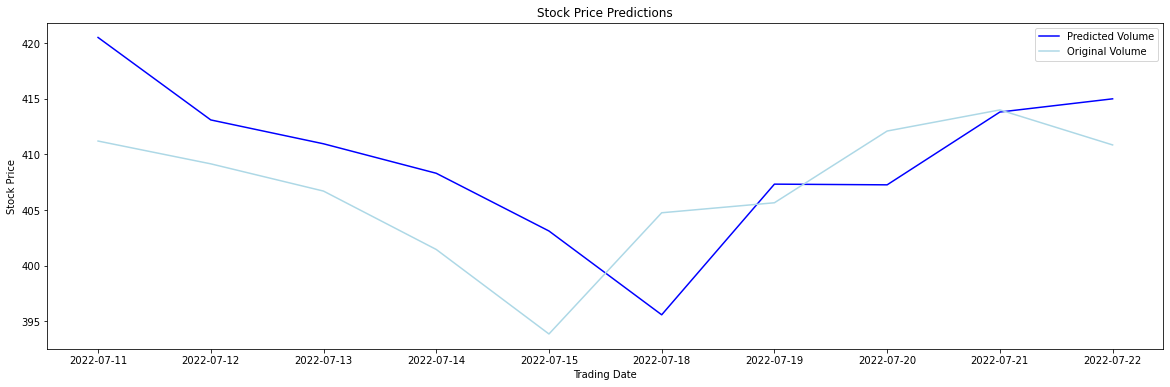

In [15]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

In [17]:
from tensorflow.keras.models import load_model

regressor.save('WIPRO.h5')

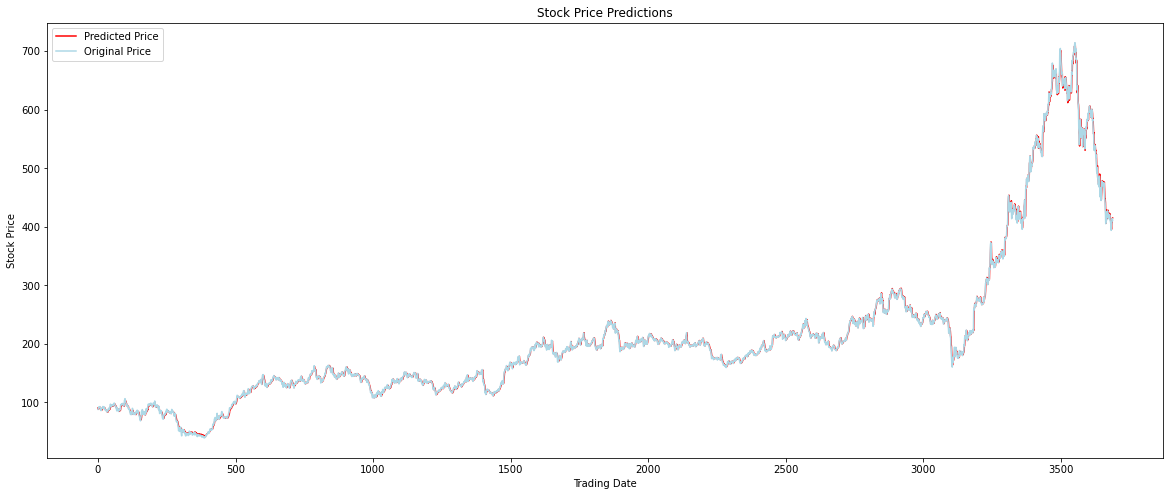

In [19]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'red', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

validation=pd.DataFrame(FullDataOrig,columns=['Original'])
validation['Prediction']=FullDataPredictions
#validation.to_csv('BLK.csv')
#from google.colab import files
#files.download('BLK.csv') 


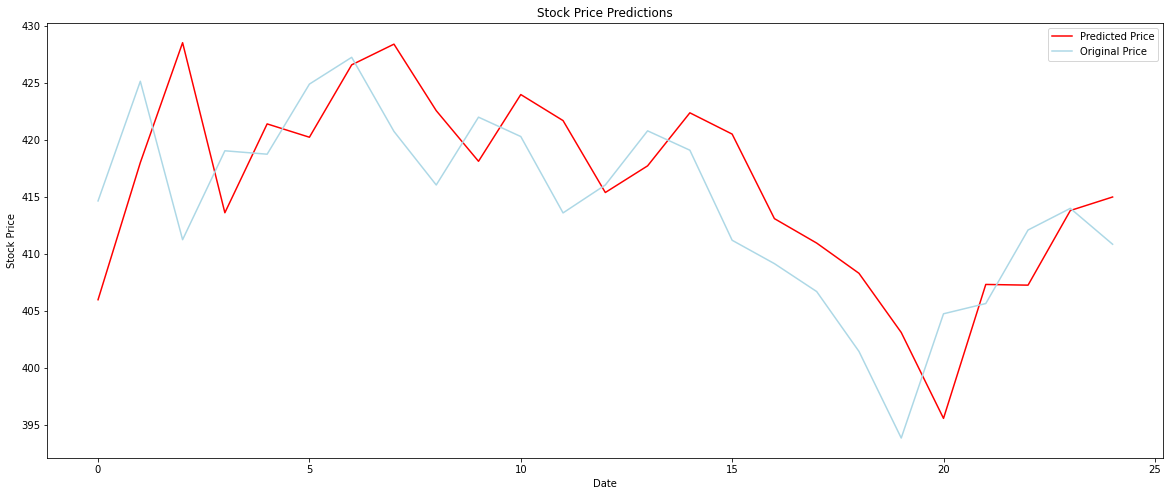

In [20]:
validation['Absolute']=abs(validation['Prediction']-validation['Original'])
#validation.mean()

new_dt = validation.filter(['Prediction'])
last1000Dayspred = new_dt[-25:].values

new_dt1 = validation.filter(['Original'])
last1000Daysorig = new_dt1[-25:].values

plt.plot(last1000Dayspred, color = 'red', label = 'Predicted Price')
plt.plot(last1000Daysorig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()
#validation.to_csv('BLKData.csv')
#from google.colab import files
#files.download('BLKData.csv') 


In [22]:
validation.tail()
validation.mean()

Original      209.282516
Prediction    209.387222
Absolute        2.749063
dtype: float64

In [25]:
1# Last 10 days prices
dt = stock.history(interval="1d", period="10d")
new_dt = dt.filter(['Close'])

last10Days = new_dt[-10:].values

##Creating an empty test list
Last10Days = []

##Append the past 60 days
Last10Days.append(last10Days)

##Converting the X_test_data into a numpy array
Last10Days = np.array(Last10Days)
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[412.4791]], dtype=float32)

In [26]:
present=stock.history(interval="1d", period="10d")
present

Open        High         Low       Close    Volume  \
Date                                                                   
2022-07-11  414.750000  415.000000  405.549988  411.200012   8344787   
2022-07-12  409.000000  414.850006  408.000000  409.149994   4888736   
2022-07-13  412.000000  412.000000  405.350006  406.700012   5978390   
2022-07-14  410.600006  410.600006  400.500000  401.450012   6580621   
2022-07-15  400.950012  404.100006  391.000000  393.850006  11164177   
2022-07-18  399.000000  405.700012  396.649994  404.750000   6816197   
2022-07-19  403.000000  407.799988  401.200012  405.649994   6448589   
2022-07-20  410.799988  417.500000  407.100006  412.100006  12618706   
2022-07-21  408.850006  417.500000  402.600006  414.000000  22691171   
2022-07-22  415.750000  417.399994  409.049988  410.850006   7734271   

            Dividends  Stock Splits  
Date                                 
2022-07-11          0             0  
2022-07-12          0             0  
2022-07-13          0             0  
2022-07-14          0             0  
2022-07-15          0             0  
2022-07-18          0             0  
2022-07-19          0             0  
2022-07-20          0             0  
2022-07-21          0             0  
2022-07-22          0             0

In [27]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[411.20001221]
 [409.1499939 ]
 [406.70001221]
 [401.45001221]
 [393.8500061 ]
 [404.75      ]
 [405.6499939 ]
 [412.1000061 ]
 [414.        ]
 [410.8500061 ]]
###################
Scaled Prices
[0.55092081 0.54788426 0.54425528 0.53647882 0.52522147 0.54136686
 0.54269996 0.55225391 0.55506823 0.55040237]


In [28]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(3685, 10, 1)
### Output Data Shape ###
(3685, 5)


In [29]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)



#### Training Data shape ####
(3680, 10, 1)
(3680, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [30]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)


[[0.08737316]
 [0.08637241]
 [0.08447106]
 [0.08880278]
 [0.08271265]
 [0.08295565]
 [0.08404219]
 [0.078095  ]
 [0.07397774]
 [0.07627941]]
====>
[0.07261962 0.07327724 0.07815219 0.07842383 0.0791529 ]
####################
[[0.08637241]
 [0.08447106]
 [0.08880278]
 [0.08271265]
 [0.08295565]
 [0.08404219]
 [0.078095  ]
 [0.07397774]
 [0.07627941]
 [0.07261962]]
====>
[0.07327724 0.07815219 0.07842383 0.0791529  0.0791386 ]
####################


In [31]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [32]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
736/736 [==============================] - 7s 6ms/step - loss: 0.0259
Epoch 2/100
736/736 [==============================] - 6s 8ms/step - loss: 0.0017
Epoch 3/100
736/736 [==============================] - 4s 6ms/step - loss: 5.2141e-04
Epoch 4/100
736/736 [==============================] - 4s 6ms/step - loss: 4.5424e-04
Epoch 5/100
736/736 [==============================] - 6s 8ms/step - loss: 4.1549e-04
Epoch 6/100
736/736 [==============================] - 4s 6ms/step - loss: 4.0484e-04
Epoch 7/100
736/736 [==============================] - 4s 6ms/step - loss: 4.0276e-04
Epoch 8/100
736/736 [==============================] - 5s 7ms/step - loss: 4.2117e-04
Epoch 9/100
736/736 [==============================] - 5s 7ms/step - loss: 3.9179e-04
Epoch 10/100
736/736 [==============================] - 4s 6ms/step - loss: 3.5999e-04
Epoch 11/100
736/736 [==============================] - 4s 5ms/step - loss: 3.5394e-04
Epoch 12/100
736/736 [==============================] - 6s 8

736/736 [==============================] - 4s 6ms/step - loss: 1.4955e-04
Epoch 96/100
736/736 [==============================] - 4s 6ms/step - loss: 1.4853e-04
Epoch 97/100
736/736 [==============================] - 6s 8ms/step - loss: 1.4880e-04
Epoch 98/100
736/736 [==============================] - 4s 6ms/step - loss: 1.5079e-04
Epoch 99/100
736/736 [==============================] - 4s 6ms/step - loss: 1.5532e-04
Epoch 100/100
736/736 [==============================] - 5s 7ms/step - loss: 1.5319e-04
############### Total Time Taken:  8 Minutes #############


In [33]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[420.96198 422.8969  423.37735 422.496   422.17783]
 [414.28165 416.0815  416.44128 415.6456  414.87238]
 [411.36285 413.0706  413.34003 412.60397 411.48895]
 [408.25342 409.87656 410.06528 409.38358 407.9631 ]
 [403.37943 404.86752 404.92682 404.3321  402.42218]]

#### Original Prices ####
[[411.20001221 409.1499939  406.70001221 401.45001221 393.8500061 ]
 [409.1499939  406.70001221 401.45001221 393.8500061  404.75      ]
 [406.70001221 401.45001221 393.8500061  404.75       405.6499939 ]
 [401.45001221 393.8500061  404.75       405.6499939  412.1000061 ]
 [393.8500061  404.75       405.6499939  412.1000061  414.        ]]


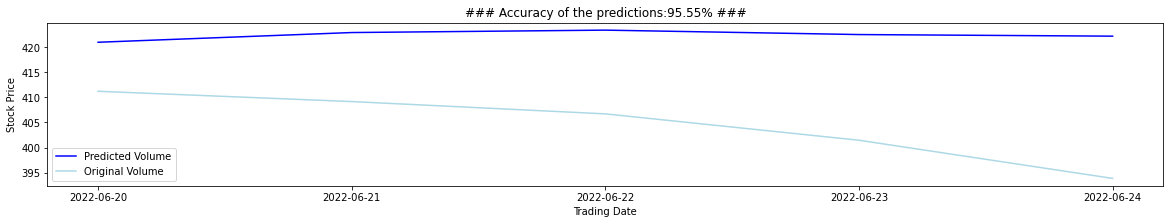

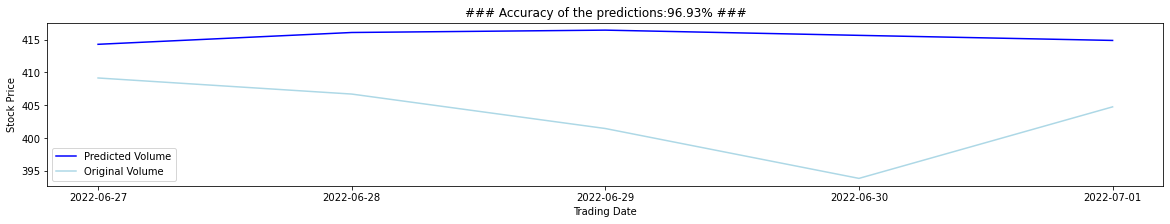

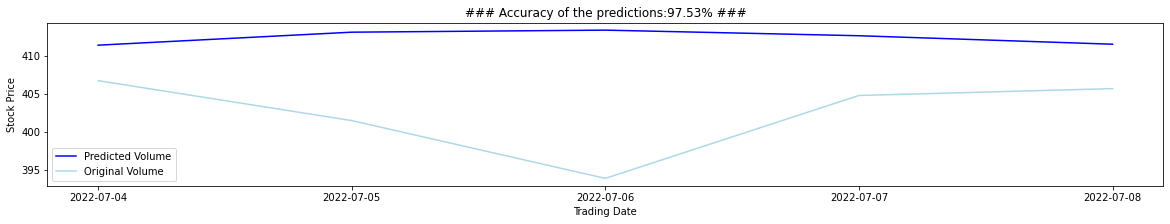

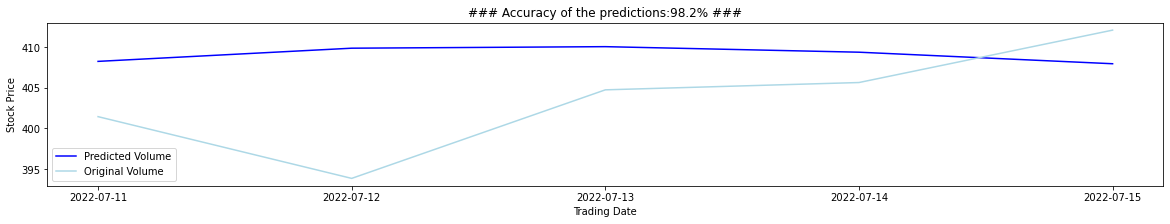

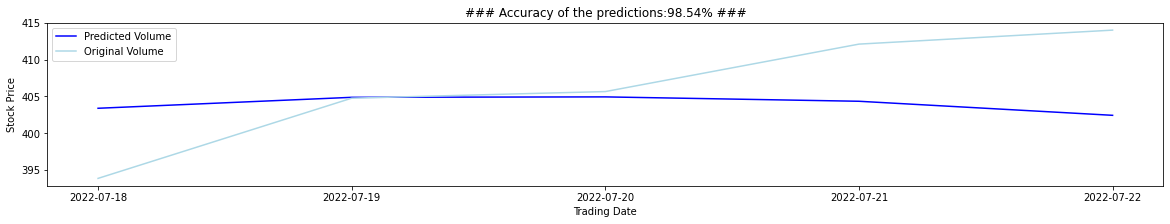

In [34]:
import matplotlib.pyplot as plt
 
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
 
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()